In [1]:
import mdtraj as md
import pyemma
from pyemma.coordinates import source
from pyemma.util.contexts import settings

import MDAnalysis as mda
import matplotlib as mpl
import matplotlib.pyplot as plt
import mdtraj as md
import pyemma
from pyemma.coordinates import source
from pyemma.util.contexts import settings

In [2]:
import numpy as np

In [5]:
arr1 = [pyemma.coordinates.load(f'../adaptive_sampling_features/feats_prod/ca_ca_{i:03d}.npy') for i in range(11)]

In [4]:
arr2 = [pyemma.coordinates.load(f'../features_v1/coord_v1_{i:03d}.npy') for i in range(9)]

In [5]:
arr3 = [pyemma.coordinates.load(f'../features_v1/t_new_{i:03d}.npy') for i in range(9)]

In [6]:
arr4 = [pyemma.coordinates.load(f'../features_v1/ca_com_v1_{i:03d}.npy') for i in range(9)]

In [7]:
arr5 = [pyemma.coordinates.load(f'../features_v1/torsions_v1_{i:03d}.npy') for i in range(9)]

In [8]:
arr6 = [pyemma.coordinates.load(f'../features_v1/ca_v1_{i:03d}.npy') for i in range(9)]

In [27]:
combo_all = [np.concatenate([a1, a2, a3, a4, a5, a6], axis=1) for a1, a2, a3, a4, a5, a6 in zip(arr3, arr4, arr2, arr1, arr5, arr6)]


In [30]:
combo_ext = [np.concatenate([a1, a2, a3, a4], axis=1) for a1, a2, a3, a4 in zip(arr3, arr4, arr2, arr1)]


Now we have to start loading these into tICA


In [32]:
labels = ['contacts','coordination','heavy dists','ca COM dists','torsions','ca-ca','combo-all','comba-ext']

[5.525439754556248]
[4.812801943923747]
[4.244289832918599]


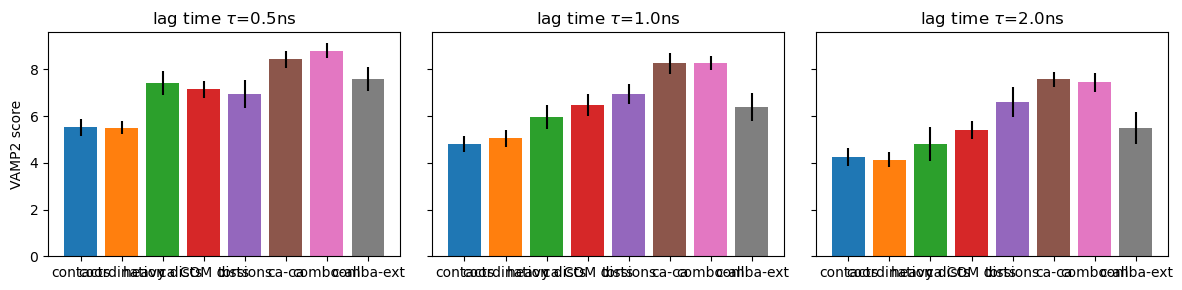

In [33]:
def score_cv(data, dim, lag, number_of_splits=10, validation_fraction=0.5):
    """Compute a cross-validated VAMP2 score.

    We randomly split the list of independent trajectories into
    a training and a validation set, compute the VAMP2 score,
    and repeat this process several times.

    Parameters
    ----------
    data : list of numpy.ndarrays
        The input data.
    dim : int
        Number of processes to score; equivalent to the dimension
        after projecting the data with VAMP2.
    lag : int
        Lag time for the VAMP2 scoring.
    number_of_splits : int, optional, default=10
        How often do we repeat the splitting and score calculation.
    validation_fraction : int, optional, default=0.5
        Fraction of trajectories which should go into the validation
        set during a split.
    """
    # we temporarily suppress very short-lived progress bars
    with pyemma.util.contexts.settings(show_progress_bars=False):
        nval = int(len(data) * validation_fraction)
        scores = np.zeros(number_of_splits)
        for n in range(number_of_splits):
            ival = np.random.choice(len(data), size=nval, replace=False)
            vamp = pyemma.coordinates.vamp(
                [d for i, d in enumerate(data) if i not in ival], lag=lag, dim=dim)
            scores[n] = vamp.score([d for i, d in enumerate(data) if i in ival])
    return scores


dim = 10

fig, axes = plt.subplots(1, 3, figsize=(12, 3), sharey=True)
for ax, lag in zip(axes.flat, [5, 10, 20]):
    torsions_scores = score_cv(arr1, lag=lag, dim=dim)
    scores = [torsions_scores.mean()]
    errors = [torsions_scores.std()]
    print(scores)
    positions_scores = score_cv(arr2, lag=lag, dim=dim)
    scores += [positions_scores.mean()]
    errors += [positions_scores.std()]
    distances_scores = score_cv(arr3, lag=lag, dim=dim)
    scores += [distances_scores.mean()]
    errors += [distances_scores.std()]
    ca_com_scores = score_cv(arr4, lag=lag, dim=dim)
    scores += [ca_com_scores.mean()]
    errors += [ca_com_scores.std()]
    torsion_scores = score_cv(arr5, lag=lag, dim=dim)
    scores += [torsion_scores.mean()]
    errors += [torsion_scores.std()]
    ca_dist_scores = score_cv(arr6, lag=lag, dim=dim)
    scores += [ca_dist_scores.mean()]
    errors += [ca_dist_scores.std()]
    combo_all_scores = score_cv(combo_all, lag=lag, dim=dim)
    scores += [combo_all_scores.mean()]
    errors += [combo_all_scores.std()]
    combo_ext_scores = score_cv(combo_ext, lag=lag, dim=dim)
    scores += [combo_ext_scores.mean()]
    errors += [combo_ext_scores.std()]
    ax.bar(labels, scores, yerr=errors, color=['C0', 'C1', 'C2','C3','C4','C5','C6','C7'])
    ax.set_title(r'lag time $\tau$={:.1f}ns'.format(lag * 0.1))
    if lag == 5:
        # save for later
        vamp_bars_plot = dict(
            labels=labels, scores=scores, errors=errors, dim=dim, lag=lag)
axes[0].set_ylabel('VAMP2 score')
fig.tight_layout()

/uufs/chpc.utah.edu/common/home/u1266568/software/pkg/miniconda3/lib/python3.9/site-packages/pyemma/coordinates/api.py:242: SyntaxWarning: "is" with a literal. Did you mean "=="?
  or len(trajfiles) is 0)):
/uufs/chpc.utah.edu/common/home/u1266568/software/pkg/miniconda3/lib/python3.9/site-packages/pyemma/coordinates/api.py:384: SyntaxWarning: "is" with a literal. Did you mean "=="?
  and (any(isinstance(item, (list, tuple, _string_types)) for item in inp) or len(inp) is 0)):
/uufs/chpc.utah.edu/common/home/u1266568/software/pkg/miniconda3/lib/python3.9/site-packages/pyemma/coordinates/api.py:388: SyntaxWarning: "is" with a literal. Did you mean "=="?
  and (any(isinstance(item, _np.ndarray) for item in inp) or len(inp) is 0)):
/uufs/chpc.utah.edu/common/home/u1266568/software/pkg/miniconda3/lib/python3.9/site-packages/pyemma/coordinates/api.py:242: SyntaxWarning: "is" with a literal. Did you mean "=="?
  or len(trajfiles) is 0)):
/uufs/chpc.utah.edu/common/home/u1266568/software/pkg/m

KeyboardInterrupt: 

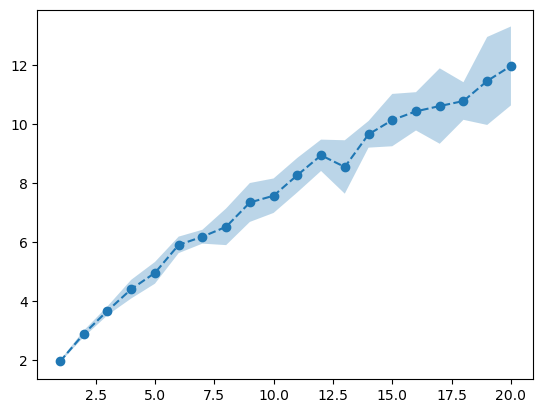

In [35]:
lags = [1, 2, 5, 10, 20]
dims = [i + 1 for i in range(20)]

fig, ax = plt.subplots()
for i, lag in enumerate(lags):
    scores_ = np.array([score_cv(arr5, dim, lag)
                        for dim in dims])
    scores = np.mean(scores_, axis=1)
    errors = np.std(scores_, axis=1, ddof=1)
    color = 'C{}'.format(i)
    ax.fill_between(dims, scores - errors, scores + errors, alpha=0.3, facecolor=color)
    ax.plot(dims, scores, '--o', color=color, label='lag={:.1f}ns'.format(lag * 0.1))
ax.legend()
ax.set_xlabel('number of dimensions')
ax.set_ylabel('VAMP2 score')
fig.tight_layout()

In [12]:
tica_dev = pyemma.coordinates.tica(arr1, lag=50,var_cutoff=0.5)
tica_out = tica_dev.get_output()
tica_concatenated = np.concatenate(tica_out)

calculate covariances:   0%|                                                                               | 0…

getting output of TICA:   0%|                                                                              | 0…

In [13]:
np.shape(tica_concatenated)

(130963, 287)

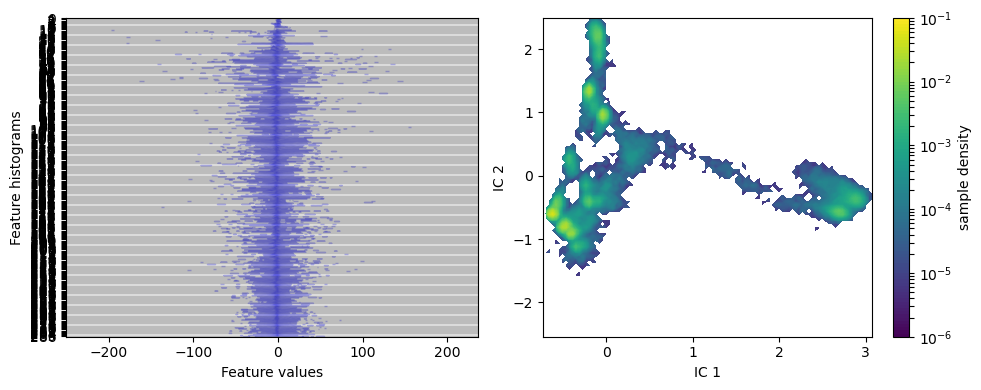

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
pyemma.plots.plot_feature_histograms(
    tica_concatenated,
    ax=axes[0],
#     feature_labels=['IC1', 'IC2', 'IC3'],
    ylog=True, ignore_dim_warning=True)
pyemma.plots.plot_density(*tica_concatenated[:, :2].T, ax=axes[1], logscale=True)
axes[1].set_xlabel('IC 1')
axes[1].set_ylabel('IC 2')
fig.tight_layout()
# plt.savefig('tica_update.png', dpi= 300)

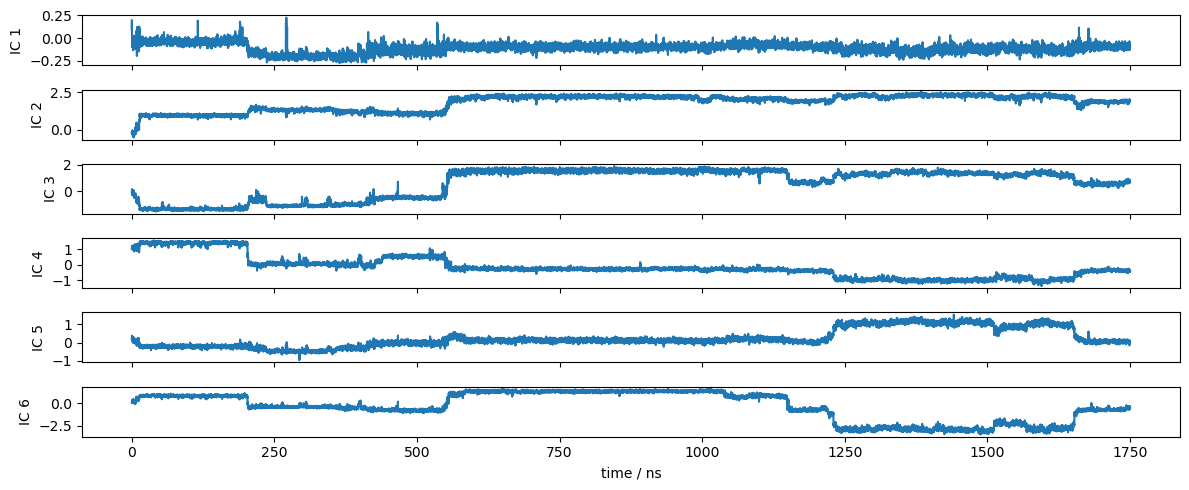

In [15]:
fig, axes = plt.subplots(6, 1, figsize=(12, 5), sharex=True)
x = 0.1 * np.arange(tica_out[0].shape[0])
for i, (ax, tic) in enumerate(zip(axes.flat, tica_out[0].T)):
    ax.plot(x, tic)
    ax.set_ylabel('IC {}'.format(i + 1))
axes[-1].set_xlabel('time / ns')
fig.tight_layout()
# plt.savefig('ics_update.png')

In [16]:
cluster = pyemma.coordinates.cluster_kmeans(
    tica_out, k=300, max_iter=200, stride=1, fixed_seed=1)
dtrajs_concatenated = np.concatenate(cluster.dtrajs)


initialize kmeans++ centers:   0%|                                                                        | 0/…

kmeans iterations:   0%|                                                                                  | 0/…

getting output of KmeansClustering:   0%|                                                                  | 0…

In [20]:
fig, ax = plt.subplots(figsize=(4, 4))
pyemma.plots.plot_density(
    *tica_concatenated[:, :2].T, ax=ax, cbar=False, alpha=0.3)
ax.scatter(*cluster.clustercenters[:, :2].T, s=5, c='C1')
ax.set_xlabel('IC 1')
ax.set_ylabel('IC 2')
fig.tight_layout()
# plt.savefig('cluster_update.png',dpi=300)

In [19]:
its = pyemma.msm.its(cluster.dtrajs, lags=200, nits=10, errors='bayes')
pyemma.plots.plot_implied_timescales(its, units='ns', dt=0.1);
# plt.savefig('its_update.png',dpi=300)

In [24]:
msm = pyemma.msm.bayesian_markov_model(cluster.dtrajs, lag=100, dt_traj='0.1 ns')
print('fraction of states used = {:.2f}'.format(msm.active_state_fraction))
print('fraction of counts used = {:.2f}'.format(msm.active_count_fraction))

pyemma.msm.estimators.bayesian_msm.BayesianMSM[72]: compute stat. inefficiencies

pyemma.msm.estimators.bayesian_msm.BayesianMSM[72]: Sampling MSMs:   0%| | 0/100

fraction of states used = 1.00
fraction of counts used = 1.00


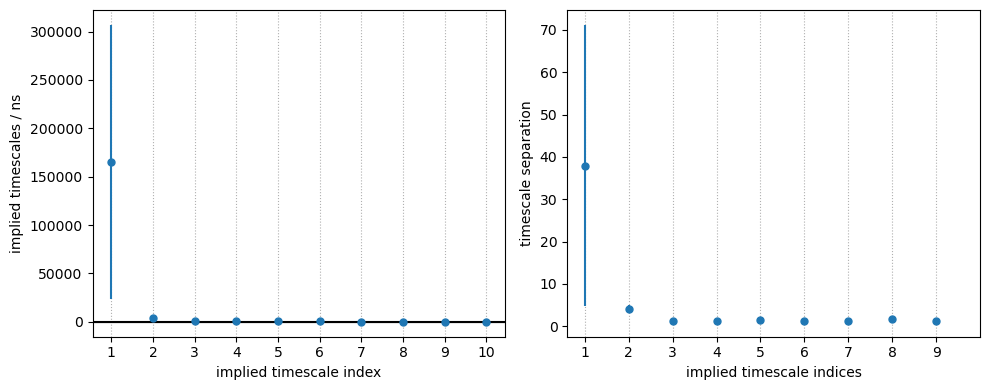

In [25]:
def its_separation_err(ts, ts_err):
    """
    Error propagation from ITS standard deviation to timescale separation.
    """
    return ts[:-1] / ts[1:] * np.sqrt(
        (ts_err[:-1] / ts[:-1])**2 + (ts_err[1:] / ts[1:])**2)


nits = 10

timescales_mean = msm.sample_mean('timescales', k=nits)
timescales_std = msm.sample_std('timescales', k=nits)

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

axes[0].errorbar(
    range(1, nits + 1),
    timescales_mean,
    yerr=timescales_std,
    fmt='.', markersize=10)
axes[1].errorbar(
    range(1, nits),
    timescales_mean[:-1] / timescales_mean[1:],
    yerr=its_separation_err(
        timescales_mean,
        timescales_std),
    fmt='.',
    markersize=10,
    color='C0')

for i, ax in enumerate(axes):
    ax.set_xticks(range(1, nits + 1))
    ax.grid(True, axis='x', linestyle=':')

axes[0].axhline(msm.lag * 0.1, lw=1.5, color='k')
axes[0].axhspan(0, msm.lag * 0.1, alpha=0.3, color='k')
axes[0].set_xlabel('implied timescale index')
axes[0].set_ylabel('implied timescales / ns')
axes[1].set_xticks(range(1, nits))
# axes[1].set_xticklabels(
#     ["{:d}/{:d}".format(k, k + 1) for k in range(1, nits + 2)],
#     rotation=45)
axes[1].set_xlabel('implied timescale indices')
axes[1].set_ylabel('timescale separation')
fig.tight_layout()
# plt.savefig('spectral_update.png',dpi=300)

estimating BayesianMSM:   0%|                             | 0/9 [00:00<?, ?it/s]

02-06-23 19:05:43 pyemma.msm.estimators.bayesian_msm.BayesianMSM[75] WARNING  Ignored error during estimation: Stationary distribution contains entries smaller than 1e-15 during iteration


/uufs/chpc.utah.edu/common/home/u1266568/software/pkg/miniconda3/lib/python3.9/site-packages/pyemma/util/statistics.py:59: UserWarning: confidence interval for constant data is not meaningful
  warnings.warn('confidence interval for constant data is not meaningful')
/uufs/chpc.utah.edu/common/home/u1266568/software/pkg/miniconda3/lib/python3.9/site-packages/msmtools/analysis/api.py:367: UserWarning: truncated eigendecomposition to contain 199 components
  warnings.warn('truncated eigendecomposition to contain %s components' % new_k, category=UserWarning)
/uufs/chpc.utah.edu/common/home/u1266568/software/pkg/miniconda3/lib/python3.9/site-packages/msmtools/analysis/api.py:367: UserWarning: truncated eigendecomposition to contain 198 components
  warnings.warn('truncated eigendecomposition to contain %s components' % new_k, category=UserWarning)
/uufs/chpc.utah.edu/common/home/u1266568/software/pkg/miniconda3/lib/python3.9/site-packages/msmtools/analysis/api.py:367: UserWarning: truncated

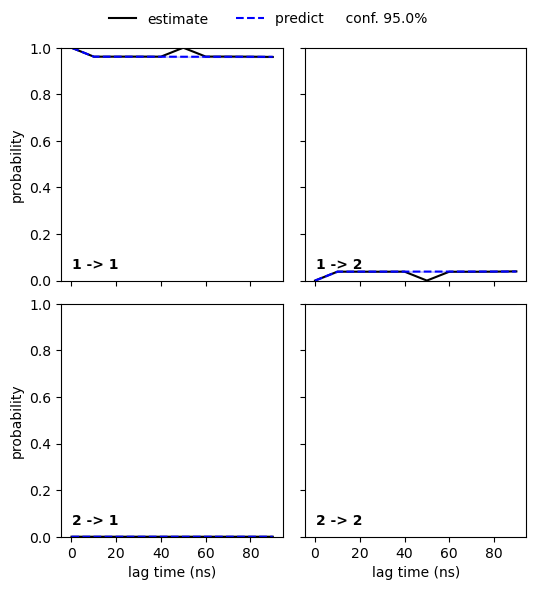

In [26]:
nstates = 2
cktest = msm.cktest(nstates)
pyemma.plots.plot_cktest(cktest, dt=0.1, units='ns');
# plt.savefig('cktets.png',dpi = 300)

In [27]:
mfpt = np.zeros((nstates, nstates))
for i in range(nstates):
    for j in range(nstates):
        mfpt[i, j] = msm.mfpt(
            msm.metastable_sets[i],
            msm.metastable_sets[j])

from pandas import DataFrame
print('MFPT / steps:')
DataFrame(np.round(mfpt, decimals=2), index=range(1, nstates + 1), columns=range(1, nstates + 1))


MFPT / steps:


,1,2
1,0.000000e+00,111452.25
2,4.225800e+08,0.00


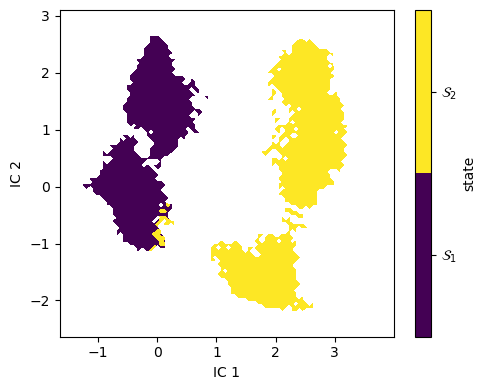

In [28]:
metastable_traj = msm.metastable_assignments[dtrajs_concatenated]

fig, ax = plt.subplots(figsize=(5, 4))
_, _, misc = pyemma.plots.plot_state_map(
    *tica_concatenated[:, :2].T, metastable_traj, ax=ax)
ax.set_xlabel('IC 1')
ax.set_ylabel('IC 2')
misc['cbar'].set_ticklabels([r'$\mathcal{S}_%d$' % (i + 1)
                             for i in range(nstates)])
fig.tight_layout()
# fig.savefig('pcca_update.png',dpi=400)

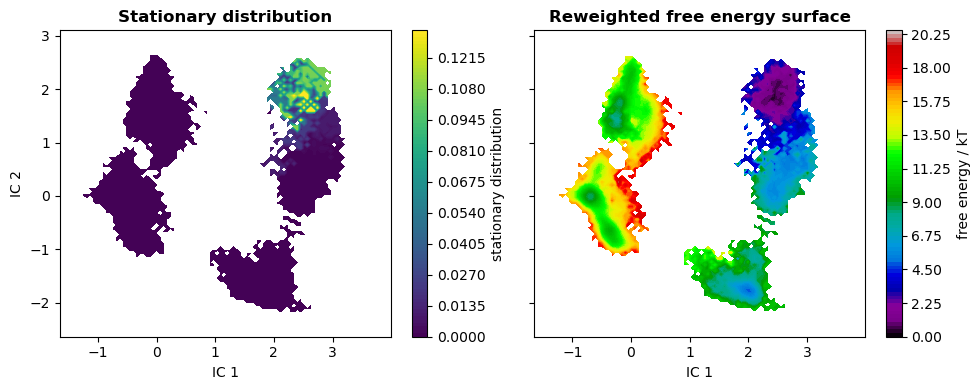

In [29]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharex=True, sharey=True)
pyemma.plots.plot_contour(
    *tica_concatenated[:, :2].T,
    msm.pi[dtrajs_concatenated],
    ax=axes[0],
    mask=True,
    cbar_label='stationary distribution')
pyemma.plots.plot_free_energy(
    *tica_concatenated[:, :2].T,
    weights=np.concatenate(msm.trajectory_weights()),
    ax=axes[1],
    legacy=False)
for ax in axes.flat:
    ax.set_xlabel('IC 1')
axes[0].set_ylabel('IC 2')
axes[0].set_title('Stationary distribution', fontweight='bold')
axes[1].set_title('Reweighted free energy surface', fontweight='bold')
fig.tight_layout()
# plt.savefig('macro_energy_update.png',dpi=400)